In [0]:
%%capture
!unzip ../data/cassiopee_data/image-nightlight_dataset.zip -d /tmp/

In [0]:
# on Colab unzip in /tmp/
DIR_images='/tmp/image-nightlight_dataset/'
path_dataframe='../data/cassiopee_data/image_nightlight_data.csv'

### Dataset Preprocessing

In [0]:
import csv
import os
import numpy as np
import skimage.io
import pandas as pd

In [0]:
# the vector needed for VGG models
mean_bgr = [103.334, 107.8797, 107.4072]

In [0]:
# function for importing one image
# return an array
def load_image(path):
  # load image
  img = skimage.io.imread(path)
  img=img[:,:,0:3]
  for i in range(0, 3):
    img[:, :, i] = img[:, :,i] - mean_bgr[i]
  #img = img / 255.0
  return img

In [0]:
# we import the 2 first columns of the .csv file
data = pd.read_csv(path_dataframe)
data=data[['id','intensity']]

In [0]:
# we display the 5 firsts rows of the dataset
data.head()

,id,intensity
0,0,30
1,1,36
2,2,48
3,3,58
4,4,62


In [0]:
# we delete the row that refers to images we don't have in the dataset
# and the truncated images due to unzip command
for i in range(data.shape[0]):
  exists = os.path.isfile(DIR_images+str(i)+'.0.png')
  if not exists:
    data.drop(i, inplace=True)
  else:
    try:
      load_image(DIR_images+str(i)+'.0.png')
    except:
      print('{} is truncated, image deleted'.format(DIR_images+str(i)+'.0.png'))
      data.drop(i, inplace=True)
      os.remove(DIR_images+str(i)+'.0.png')

/tmp/image-nightlight_dataset/2663.0.png is truncated, image deleted


In [0]:
# we print the number of files in our dataset
m=data.shape[0]
print("There are {} images in the dataset".format(m))

There are 21525 images in the dataset


### Ids & Labels loading

#### Classes restriction

In [0]:
#0-63 intensities values to 0-2
def extract_value_from(Value):
  if (Value<=2):
    Value=0
  elif (Value<=34):
    Value=1
  else:
    Value=2
  return Value

data['intensity'] = data['intensity'].apply(lambda x: extract_value_from(x))

In [0]:
data.head()

,id,intensity
0,0,1
1,1,2
2,2,2
3,3,2
4,4,2


#### Classe balancing 

In [0]:
data['intensity'].value_counts()

0    14646
1     3649
2     3230
Name: intensity, dtype: int64

In [0]:
from sklearn.utils import resample
# Separate majority and minority classes
class_majority = data[data['intensity']==0]
classes_minority = data[data['intensity']!=0]
 
# Downsample majority class
class_majority_downsampled = resample(class_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=3649)     # to match minority class
 
# Combine minority class with downsampled majority class
data = pd.concat([class_majority_downsampled, classes_minority])
data = data.sample(frac=1).reset_index(drop=True)

In [0]:
data['intensity'].value_counts()

1    3649
0    3649
2    3230
Name: intensity, dtype: int64

#### Numpy arrays

In [0]:
labels=data['intensity'].to_numpy()
list_IDs=data['id'].to_numpy()

NameError: ignored

In [0]:
# we print the number of files in our dataset
m=data.shape[0]
print("There are {} images in the dataset".format(m))

There are 10528 images in the dataset


#### Split the dataset into train set and dev set

In [0]:
m_test=1000
permutations=np.arange(m)
np.random.shuffle(permutations)
list_IDs_shuffled=np.take(list_IDs,permutations)
labels_shuffled=np.take(labels,permutations)
# train set
list_IDs_train=list_IDs_shuffled[m_test:]
labels_train=labels_shuffled[m_test:]
print('There are {} training images'.format(labels_train.shape[0]))
# test set
list_IDs_test=list_IDs_shuffled[:m_test]
labels_test=labels_shuffled[:m_test]
print('There are {} testing images'.format(labels_test.shape[0]))
# deleting useless variables
del permutations, list_IDs_shuffled, labels_shuffled

There are 9528 training images
There are 1000 testing images


#VGG-f

##Download Weights

In [0]:
# execute if you haven't donwloaded the weights yet
!wget http://www.vlfeat.org/matconvnet/models/imagenet-vgg-f.mat

##Model + Training

### Read .mat file and extract the weights of the conv layers

In [0]:
import scipy.io
mat = scipy.io.loadmat('imagenet-vgg-f.mat')
dic={}
print('Model Summary:')
for i in range(21):
  print(mat['layers'][0][i][0][0][0][0])
  name=mat['layers'][0][i][0][0][0][0]
  if (name[0:4]=='conv'):
    weights=mat['layers'][0][i][0][0][2][0]
    dic[name+'_weight']=weights[0]
    dic[name+'_biais']=np.resize(weights[1],(weights[1].shape[0],))
del mat
del weights
  

In [0]:
print(dic.keys())

### Model definition

In [0]:
import tensorflow as tf
import numpy as np

In [0]:
#Reset graph and deleting existing model
tf.keras.backend.clear_session()

In [0]:
data=np.load('/content/drive/My Drive/caffe-to-keras/data.npy', allow_pickle=True, encoding='latin1',fix_imports=True)
data=data.item(0)

In [0]:
weights_conv1=(data['conv1']['weights'],data['conv1']['biases'])
weights_conv2=(data['conv2']['weights'],data['conv2']['biases'])
weights_conv3=(data['conv3']['weights'],data['conv3']['biases'])
weights_conv4=(data['conv4']['weights'],data['conv4']['biases'])
weights_conv5=(data['conv5']['weights'],data['conv5']['biases'])
weights_conv6=(data['conv6']['weights'],data['conv6']['biases'])
weights_conv7=(data['conv7']['weights'],data['conv7']['biases'])
weights_conv8=(data['conv8']['weights'],data['conv8']['biases'])
del data

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (11,11),strides=4, activation='relu', input_shape=(400, 400, 3), weights=weights_conv1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(256, (5,5), activation='relu', padding='same', weights=weights_conv2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', weights=weights_conv3),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', weights=weights_conv4),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', weights=weights_conv5),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(4096, (6,6), activation='relu', strides=6, weights=weights_conv6),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(4096, (1,1), activation='relu', weights=weights_conv7),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(3, (1,1), activation='relu', weights=weights_conv8),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])
del weights_conv1, weights_conv2, weights_conv3, weights_conv4, weights_conv5, weights_conv6, weights_conv7, weights_conv8

W0619 07:22:46.904442 139622591252352 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Data Generator

#### Creation of our DataGenerator

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(400,400,3), n_classes=3):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp,indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = load_image(DIR_images+str(ID)+'.0.png')

            # Store class
            y[i] = self.labels[indexes[i]]

        return X, y

In [0]:
params = {'dim': (400,400,3), 'batch_size': 32, 'n_classes': 3}
training_generator = DataGenerator(list_IDs_train, labels_train, **params)
validation_generator = DataGenerator(list_IDs_test, labels_test, **params)

NameError: ignored

### Callbacks

In [0]:
class myCallback(tf.keras.callbacks.Callback):   
  def on_epoch_end(self,epochs,logs={}):
    if (start-time.time()>42300):
      self.model.save_weights("model.h5")
      print("Model saved on disk")
      self.model.stop_training=True

callbacks=myCallback()
checkpoint = ModelCheckpoint('model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [0]:
# run for every training
#tensorboard=tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir='/tmp/logs/{}'.format(time()), histogram_freq=1)

### Model compilation and training

In [0]:
adam=tf.keras.optimizers.Adam(lr=10**-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['acc'])
# maybe we can try sgd optimizer with momentum=0.9, weight decay=5*10*-4

In [0]:
model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=20, callbacks=[callbacks])
#model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=10, use_multiprocessing=True, workers=6, callbacks=[tensorboard])

Epoch 1/20
297/297 [==============================] - 108s 362ms/step - loss: 0.5128 - acc: 0.8132 - val_loss: 0.4934 - val_acc: 0.8256
Epoch 2/20
297/297 [==============================] - 104s 351ms/step - loss: 0.5063 - acc: 0.8191 - val_loss: 0.4957 - val_acc: 0.8246
Epoch 3/20
297/297 [==============================] - 104s 352ms/step - loss: 0.5060 - acc: 0.8162 - val_loss: 0.5002 - val_acc: 0.8276
Epoch 4/20
297/297 [==============================] - 104s 351ms/step - loss: 0.5067 - acc: 0.8150 - val_loss: 0.4867 - val_acc: 0.8226
Epoch 5/20
297/297 [==============================] - 104s 351ms/step - loss: 0.5035 - acc: 0.8167 - val_loss: 0.4884 - val_acc: 0.8185
Epoch 6/20
297/297 [==============================] - 104s 351ms/step - loss: 0.4996 - acc: 0.8231 - val_loss: 0.4901 - val_acc: 0.8327
Epoch 7/20
297/297 [==============================] - 104s 351ms/step - loss: 0.4956 - acc: 0.8210 - val_loss: 0.4815 - val_acc: 0.8337
Epoch 8/20
297/297 [============================

### Save and load weights

In [0]:
import h5py

In [0]:
model.save_weights("model.h5")

### Evaluation

In [0]:
model.evaluate_generator(validation_generator)

#### Confusion Matric

In [0]:
from sklearn.metrics import confusion_matrix
labels_pred=[]
for ID in list_IDs_test:
  x=np.expand_dims(load_image(DIR_images+str(ID)+'.0.png'),axis=0)
  labels_pred.append(model.predict_classes(x)[0])

In [0]:
assert len(y_pred)==len(labels)

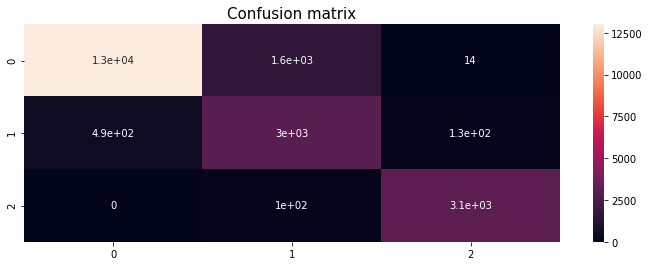

In [0]:
from seaborn import heatmap
import matplotlib.pyplot as plt
labels_pred = np.asarray(labels_pred)
plt.rcParams['figure.figsize'] = (12, 4)
heatmap(confusion_matrix(labels_test, labels_pred, labels=[0,1,2]), annot = True)
plt.title('Confusion matrix', fontsize = 15)
plt.show()

### Model cleaning

In [0]:
tf.keras.backend.clear_session()
del model